In [1]:
%matplotlib notebook

In [2]:
# loading standard modules
import numpy as np
import math
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from skimage.color import rgb2grey

from random import randint

# loading custom module (requires file asg1.py in the same directory as the notebook file)
from asg1 import Figure, KmeansPresenter

In [3]:
class MyKmeansApp:

    def __init__(self, img, num_clusters=2, weightXY=1.0):
        self.k = num_clusters
        self.w = weightXY
        self.iteration = 0   # iteration counter
        self.energy = np.infty  # energy - "sum of squared errors" (SSE)

        num_rows = self.num_rows = img.shape[0]
        num_cols = self.num_cols = img.shape[1]

        self.im = img
        
        self.means = np.zeros((self.k,5),'d') # creates a zero-valued (double) matrix of size Kx5
        self.init_means()
      
        self.no_label = num_clusters  # special label value indicating pixels not in any cluster (e.g. not yet) 

        # mask "labels" where pixels of each "region" will have a unique index-label (like 0,1,2,3,..,K-1)
        # the default mask value is "no-label" (K) implying pixels that do not belong to any region (yet)
        self.labels = np.full((num_rows, num_cols), fill_value=self.no_label, dtype=np.int)
        
        self.fig = Figure()
        self.pres = KmeansPresenter(img, self)
        self.pres.connect_figure(self.fig)
       
    def run(self):
        self.fig.show()
        
    def init_means(self):      
        self.iteration = 0           # resets iteration counter 
        self.energy = np.infty       # and the energy

        poolX = range(self.num_cols)
        poolY = range(self.num_rows)
        
        # generate K random pixels (Kx2 array with X,Y coordinates in each row)
        random_pixels = np.array([np.random.choice(poolX,self.k),np.random.choice(poolY,self.k)]).T
        
        for label in range(self.k):
            self.means[label,:3] = self.im[random_pixels[label,1],random_pixels[label,0],:3]
            self.means[label,3] = random_pixels[label,0]
            self.means[label,4] = random_pixels[label,1]
    
    # This function compute average values for R, G, B, X, Y channel (feature component) at pixels in each cluster
    # represented by labels in given mask "self.labels" storing indeces in range [0,K). The averages should be
    # saved in (Kx5) matrix "self.means". The return value should be the number of non-empty clusters. 
    def compute_means(self):
        labels = self.labels
        non_empty_clusters = 0
        means = self.means
        k = self.k
        s = set()
        count = np.zeros((k,1))
        means[:,:] = 0
        
        # Your code below should compute average values for R,G,B,X,Y features in each segment 
        # and save them in (Kx5) matrix "self.means". For empty clusters set the corresponding mean values 
        # to infinity (np.infty). Report the correct number of non-empty clusters by the return value.
        for row in xrange(self.num_rows):
            for col in xrange(self.num_cols):
                label = labels[row,col]
                if label < k:
                    means[label,0] += img[row,col,0]
                    means[label,1] += img[row,col,1]
                    means[label,2] += img[row,col,2]
                    means[label,3] += row
                    means[label,4] += col
                    count[label] += 1

                    if label not in s:
                        s.add(label)
                        non_empty_clusters += 1

        for i in xrange(k):
            if i not in s:
                means[i] = np.inf
            else:
                means[i] /= count[i]
                
        return non_empty_clusters
            
    # The segmentation mask is used by KmeanPresenter to paint segments in distinct colors
    # NOTE: valid region labels are in [0,K), but the color map in KmeansPresenter
    #       accepts labels in range [0,K] where pixels with no_label=K are not painted/colored.
    def get_region_mask(self):  
        return self.labels  
    
    # This function computes optimal (cluster) index/label in range 0,1,...,K-1 for pixel x,y based on 
    # given current cluster means (self.means). The functions should save these labels in "self.labels".
    # The return value should be the corresponding optimal SSE.
    def compute_labels(self):
        shape = (self.num_rows,self.num_cols)
        opt_labels = np.full(shape, fill_value=self.no_label, dtype=np.int) # HINT: you can use this array to store and update
                                                                            # currently the best label for each pixel.
        
        min_dist = np.full(shape, fill_value=np.inf)  # HINT: you can use this array to store and update 
                                                      # the (squared) distance from each pixel to its current "opt_label".
                                                      # use 'self.w' as a relative weight of sq. errors for X and Y components
        
        labels = self.labels
        means = self.means
        w = self.w
        # Replace the code below by your code that computes "opt_labels" array of labels in range [0,K) where 
        # each pixel's label is an index 'i' such that self.mean[i] is the closest to R,G,B,X,Y values of this pixel.
        # Your code should also update min_dist so that it contains the optmail squared errors  
        for row in xrange(self.num_rows):
            for col in xrange(self.num_cols):
                for k in xrange(self.k):
                    v = min_dist[row, col]
                    rgbxy = np.append(img[row, col], (row, col))
                    rgbxy = rgbxy.astype(float)
                    tmp = np.power(rgbxy - means[k], 2)
                    tmp[3:] *= w
                    tmp = abs(np.sum(tmp))
                    if tmp < v:
                        min_dist[row, col] = tmp
                        opt_labels[row, col] = k
        
        # update the labels based on opt_labels computed above
        self.labels = opt_labels
        
        # returns the optimal SSE (corresponding to optimal clusters/labels for given means)
        return min_dist.sum()
            
    # The function below is called by "on_key_down" in KmeansPresenter".
    # It's goal is to run an iteration of K-means procedure 
    # updating the means and the (segment) labels 
    def compute_k_means_clusters(self):  
        self.iteration += 1  

        # the main two steps of K-means algorithm
        energy = self.compute_labels()
        num_clusters = self.compute_means()

        # computing improvement and printing some information
        num_pixels = self.num_rows*self.num_cols
        improve_per_pixel = (self.energy - energy)/num_pixels
        energy_per_pixel = energy/num_pixels
        self.energy = energy
        
        self.fig.ax.text(0, -8,   # text location  
                         'iteration = {:_>2d},  clusters = {:_>2d},  SSE/p = {:_>7.1f},   improve/p = {:_>7.3f}    '.format(
                          self.iteration,       num_clusters,        energy_per_pixel,    improve_per_pixel),
                          bbox={'facecolor':'white', 'edgecolor':'none'})
       
        return improve_per_pixel

### Notes about K-means implementation:
1. press 'i'-key for each (i)teration of K-means 
2. press 'c'-key to run K-means to (c)onvergence (when energy improvement is less than given threshold)
3. press 'v'-key to run K-means to convergence with (v)isualization of each iteration
4. press 'r'-key to start over from (r)andom means
5. press 's'-key to change to a random (s)olid color-palette for displaying clusters
6. press 't'-key to change to a random (t)ransparent palette for displaying clusters
7. press 'm'-key to change to the (m)ean-color palette for displaying clusters

<IPython.core.display.Javascript object>


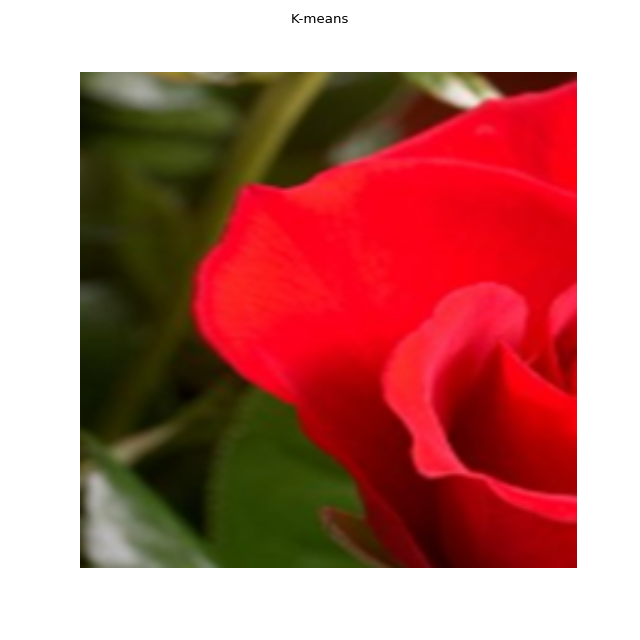

In [4]:
img = plt.imread('images/rose.bmp')
app = MyKmeansApp(img[:200,:200], num_clusters=4, weightXY=2.0)
app.run()

In [ ]:
img = plt.imread('images/tools.bmp')
app = MyKmeansApp(img, num_clusters=3, weightXY=0.0)
app.run()

In [ ]:
rgb = np.array([255, 120, 0])
rgbxy = np.append(rgb, (0, 0))
rgbxy[3:] = 30
print rgbxy

s = set()
print s